In [1]:
import tensorflow_datasets as tfds
#import tensorflow_text as tf_text
from datetime import datetime
#!pip install tensorflow_datasets
#!pip install tensorflow-text
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense
from tensorflow.keras import Sequential
import pandas as pd
import pandas as pd
print(tf.__version__)

2.7.0


# Entrenamiento de los modelos de Deep Learning https://playground.tensorflow.org/

## REGRESION LINEAL: Y(x)=w*x+b

,x,y
0,-10.000000,-55.049816
1,-9.933110,-50.665413
2,-9.866220,-51.293583
3,-9.799331,-51.828117
4,-9.732442,-52.675873


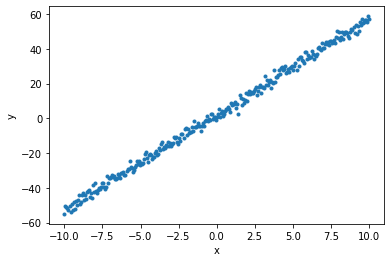

In [2]:
##Generacion de datos
numbers= 300
x = tf.linspace(-10.0, 10.0,numbers )
inter_true=tf.constant(2.3)
pendi_true=tf.constant(5.5)
noise = tf.random.normal(
    (numbers,), mean=0.001, stddev=1.9, dtype=tf.dtypes.float32)
y = pendi_true*x+inter_true+noise
plt.scatter(x,y,marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend
dict_={'x':x,'y':y}
df =pd.DataFrame(dict_)
df.head()

In [3]:
pandas_dataset = tf.data.Dataset.from_tensor_slices((df['x'].values,df['y'].values))
pandas_dataset.element_spec
len_df =pandas_dataset.cardinality().numpy()
print(len_df)

300


In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,batch_=30):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(len_df, seed=12)
    
    train_size = int(train_split * len_df)
    val_size = int(val_split * len_df)
    
    train_ds = ds.take(train_size).batch(batch_).prefetch(tf.data.AUTOTUNE)
    val_ds = ds.skip(train_size).take(val_size).batch(batch_).prefetch(tf.data.AUTOTUNE)
    test_ds = ds.skip(train_size).skip(val_size).batch(batch_).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [5]:
train_data,val_data, test_data = get_dataset_partitions_tf(pandas_dataset, train_split=0.7, val_split=0.15, test_split=0.15)

### Entrenamiento

In [6]:
## Definir variables
w = tf.Variable(np.random.normal(), name='w')
b = tf.Variable(np.random.normal(), name='b')

## Salida de la red neuronal (prediccion y_pred)
def output_(w,b,x,activation=tf.keras.activations.linear):
    y_pred = tf.add(tf.multiply(w, x), b)
    return  activation(y_pred)
## Funcion de costo: regresion=>MSE
def loss_mse(y_pred,y):
    return tf.reduce_mean(tf.square(y_pred-y))
    
Epocas=45
loss_hist = []
loss_hist_val = []
loss_batch =[]
##Learning rate
learning_rate=0.008
for st in range(Epocas):  ## Loop de epocas
    for dsx, dsy  in train_data: ## Loop de datos de entrenamiento
        ## Gradiente
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch([w,b])
            ## Obtener salida de la red
            y_pred = output_(w,b,dsx)
            ## Calcular funcion de costo
            loss = loss_mse(y_pred,dsy)
        ## Calcular gradiente respecto a w,b
        dl_dw,dl_db = tape.gradient(loss, [w,b])
        ## Actualizar pesos y bias
        w = w - learning_rate * dl_dw
        b = b - learning_rate * dl_db    
        loss_batch.append(loss.numpy())
    loss_v=[]
    for dsx_val,dsy_val in val_data: ## Loop de datos de validacion
        y_pred_val = output_(w,b,dsx_val)
        loss_batch_val = loss_mse(y_pred_val,dsy_val)
        loss_v.append(loss_batch_val.numpy())
    
    
    loss_val =np.mean(loss_v)
    loss_epoc = np.mean(loss_batch)
    loss_hist.append(loss_epoc)
    loss_hist_val.append(loss_val)
    if st%10==0:
        print('epoch: {}; loss_mse_train: {}; loss_mse_validation: {};  w: {}; b: {}'.format(st,loss_epoc,loss_val,w,b))
        


epoch: 0; loss_mse_train: 196.91368103027344; loss_mse_validation: 6.009893894195557;  w: 5.452190399169922; b: 0.9781931042671204
epoch: 10; loss_mse_train: 21.818544387817383; loss_mse_validation: 3.5488133430480957;  w: 5.483185768127441; b: 1.7943130731582642
epoch: 20; loss_mse_train: 13.230594635009766; loss_mse_validation: 2.774782180786133;  w: 5.4611616134643555; b: 2.1070377826690674
epoch: 30; loss_mse_train: 10.181009292602539; loss_mse_validation: 3.3637778759002686;  w: 5.492298603057861; b: 2.2130565643310547
epoch: 40; loss_mse_train: 8.603874206542969; loss_mse_validation: 3.1425108909606934;  w: 5.460763931274414; b: 2.2387185096740723


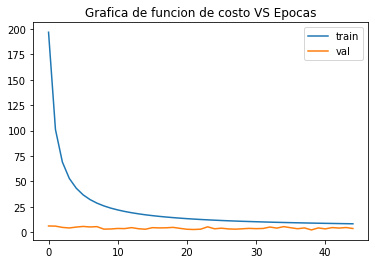

In [7]:

plt.plot(loss_hist,label='train')
plt.plot(loss_hist_val,label='val')
plt.title('Grafica de funcion de costo VS Epocas')
plt.legend()

In [17]:
loss_t=[]
x_test=[]
y_test=[]
for dsx_test,dsy_test in test_data:
        y_pred_test = output_(w,b,dsx_test)
        loss_batch_test = loss_mse(y_pred_test,dsy_test)
        loss_t.append(loss_batch_test.numpy())
        x_test.append(dsx_test.numpy())
        y_test.append(dsy_test.numpy())
loss_test =np.mean(loss_t)
print("Funcion de costo para datos prueba:",loss_test)

Funcion de costo para datos prueba: 3.930233


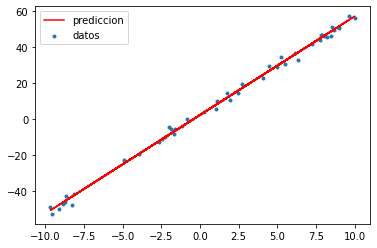

In [18]:
# Prediccion de la regresion!
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)
plt.scatter(x_test,y_test,marker='.', label='datos')
plt.plot(x_test,x_test*w+b,color='red', label='prediccion')
plt.legend()

## Clasificacion:  $yln(pred) + (1 − y )ln( 1 − pred)$ Cross-entropy

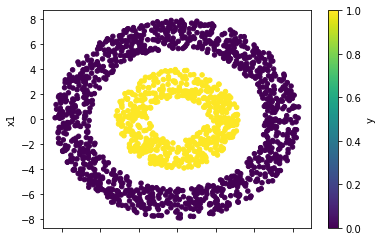

In [41]:
data_x = tf.random.uniform(
    (5000,2), minval=-10, maxval=10,seed=42, dtype=tf.float64).numpy()
def label_circle(x,y):
    if  1*np.sqrt(10)<x**2+y**2<= 5*np.sqrt(10):
        return  1
    elif  20*np.sqrt(10)>=x**2+y**2>= 10*np.sqrt(10):
        return 0
    else:
        return 2
def squared_circle(x,y):
    return x**2, y**2
    
df =pd.DataFrame(data_x,columns=['x0','x1'])
df['y'] =df.apply(lambda x: label_circle(x['x0'],x['x1']), axis=1)
df[['x02','x12']] =df.apply(lambda x: squared_circle(x['x0'],x['x1']), axis=1, result_type="expand")
df=df[df['y']!=2]
df.plot.scatter(x='x0',y='x1', c='y',colormap='viridis')

In [42]:
def preprocess(x,y):
    return tf.cast(x,tf.float64),tf.cast(y,tf.float64)
pandas_dataset_X = tf.data.Dataset.from_tensor_slices(df[['x0','x1']].values)
pandas_dataset_y = tf.data.Dataset.from_tensor_slices(df['y'].values)
dataset = tf.data.Dataset.zip((pandas_dataset_X,pandas_dataset_y))
len_df =dataset.cardinality().numpy()
dataset=dataset.shuffle(len_df)
dataset=dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.AUTOTUNE)

print(len_df,dataset.element_spec)

1715 (TensorSpec(shape=(2,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))


In [69]:
BATCH=50
train_data_class,val_data_class, test_data_class = get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1,batch_=BATCH)

In [56]:
##DEfinicion de variables
w = tf.Variable(np.random.normal(size=(2, 1)), name='w',dtype=tf.float64)
b = tf.Variable(np.random.normal(size=(1)), name='b',dtype=tf.float64)


##Salida de red neuronal (prediccion y_pred)
def output_(w,b,x,activation=tf.nn.sigmoid):
    y_pred = tf.add(tf.matmul(tf.cast(tf.math.pow(x,2),tf.float64),w), b)
    return  activation(y_pred)

## Calculo de funcion de costo, clasificacion=>cross entropy
def cross_entropy_loss(y_pred, y_true):
    ### Cross entropy
    #y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    #return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred+1e-9)+(1. - y_true) * tf.math.log(1.-y_pred+1e-9)))/len(y_pred)
    ### Cross entropy usado por keras
    cce = tf.keras.losses.BinaryCrossentropy()
    return cce(y_true,y_pred)
##Definicion de exactitud
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float64))


  

In [70]:
Epocas=100
loss_hist = []
loss_hist_val = []
loss_batch =[]
acc_batch =[]
learning_rate=0.001

for st in range(Epocas): ## loop de epocas
    for dsX, dsy  in train_data_class: ## loop de datos
        ##calculo de gradiente
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch([w,b])
            ##salida de red    
            y_pred = output_(w,b,dsX)
            ##calculo de la funcion de costo
            loss = cross_entropy_loss(y_pred,dsy)
            ##calculo de accuracy
            acc =  accuracy(y_pred, dsy)
        ## calculo de gradientes de w ,b
        dl_dw,dl_db = tape.gradient(loss, [w,b])
        
        ##actualizar w, b
        w = w - learning_rate * dl_dw
        b = b - learning_rate * dl_db    
        loss_batch.append(loss.numpy())
        acc_batch.append(acc.numpy())
    loss_v=[]

    for ds_valX,ds_valy in val_data_class: ##loop de validacion
        y_pred_val = output_(w,b,ds_valX)
        loss_batch_val = cross_entropy_loss(y_pred_val, ds_valy)
        acc =  accuracy(y_pred_val, ds_valy)
        
        loss_v.append(loss_batch_val.numpy())
    loss_val =np.mean(loss_v)
    
    loss_epoc = np.mean(loss_batch)
    acc_epoc = np.mean(acc_batch)
    loss_hist.append(loss_epoc)
    loss_hist_val.append(loss_val)
    
    
    
    if st%10==0:
        print('epoch: {}; loss_mse_train: {}; loss_mse_validation: {}; acc_train: {}; w: {}; b: {}'.format(st,loss_epoc,loss_val,acc_epoc,w,b))

epoch: 0; loss_mse_train: 0.4314913089786257; loss_mse_validation: 0.3849608674645424; acc_train: 0.6854545454545454; w: [[-0.04351627]
 [-0.04996978]]; b: [-0.3892122]
epoch: 10; loss_mse_train: 0.4276194532776808; loss_mse_validation: 0.4617133140563965; acc_train: 0.6844628099173554; w: [[-0.04547689]
 [-0.05264606]]; b: [-0.3416576]
epoch: 20; loss_mse_train: 0.42300881985194827; loss_mse_validation: 0.37613673508167267; acc_train: 0.6846753246753248; w: [[-0.04753949]
 [-0.05431124]]; b: [-0.29465479]
epoch: 30; loss_mse_train: 0.4200117211394046; loss_mse_validation: 0.38857627660036087; acc_train: 0.6837159614578969; w: [[-0.04866362]
 [-0.05367654]]; b: [-0.24769537]
epoch: 40; loss_mse_train: 0.41686113186518076; loss_mse_validation: 0.42490825057029724; acc_train: 0.6830741210009502; w: [[-0.04969226]
 [-0.05463412]]; b: [-0.20131524]
epoch: 50; loss_mse_train: 0.4133993927024159; loss_mse_validation: 0.3959684893488884; acc_train: 0.6826801629742806; w: [[-0.0512337 ]
 [-0.0

In [71]:
## accuracy test
y_pred_bath=[]
y_true=[]
x_true=[]
for ds_tesx,ds_tesy in test_data_class:
    y_pred=output_(w,b,ds_tesx)
    y_pred_bath.append(y_pred.numpy())
    y_true.append(ds_tesy.numpy())
    x_true.append(ds_tesx.numpy())
print('accuracy test: {}'.format(accuracy(np.concatenate(y_pred_bath), np.concatenate(y_true))))

accuracy test: 0.6918604651162791


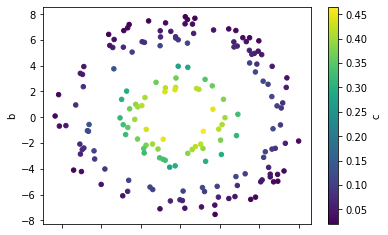

In [72]:
arry= np.stack((np.squeeze(np.concatenate(x_true))[:,0],np.squeeze(np.concatenate(x_true))[:,1],np.squeeze(np.concatenate(y_pred_bath))),axis=1)
df1= pd.DataFrame(arry,columns=[['a','b','c']])
df1.plot.scatter(x='a',y='b', c='c',colormap='viridis')

## Creacion de Modelos en TF.keras

### Regresion

In [77]:
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
model = Sequential()
model.add(tf.keras.Input((1,)))
model.add(Dense(1))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  return r2

model.compile(loss='mse',
              optimizer=sgd,metrics=['mse',R_squared])
history=model.fit(train_data ,epochs=2,verbose=1)
model.get_weights()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/2
7/7 [==============================] - 1s 2ms/step - loss: 197.6463 - mse: 197.6463 - R_squared: 0.8332
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 4.3706 - mse: 4.3706 - R_squared: 0.9954


[array([[5.3921065]], dtype=float32), array([2.2580383], dtype=float32)]

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### Clasificacion

In [83]:
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
model = Sequential()
model.add(tf.keras.Input((2,)))
model.add(tf.keras.layers.Lambda(lambda x: x ** 2))
model.add(Dense(1))
model.add(Activation('sigmoid'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,metrics=['accuracy'])
history=model.fit(train_data_class, validation_data=val_data_class ,epochs=10,verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
28/28 [==============================] - 1s 16ms/step - loss: 6.0370 - accuracy: 0.6421 - val_loss: 2.1839 - val_accuracy: 0.6959
Epoch 2/10
28/28 [==============================] - 0s 9ms/step - loss: 0.7011 - accuracy: 0.7485 - val_loss: 0.2475 - val_accuracy: 0.8947
Epoch 3/10
28/28 [==============================] - 0s 9ms/step - loss: 0.2293 - accuracy: 0.8994 - val_loss: 0.2012 - val_accuracy: 0.9123
Epoch 4/10
28/28 [==============================] - 0s 9ms/step - loss: 0.2072 - accuracy: 0.9497 - val_loss: 0.1795 - val_accuracy: 0.9708
Epoch 5/10
28/28 [==============================] - 0s 9ms/step - loss: 0.1759 - accuracy: 0.9730 - val_loss: 0.1796 - val_accuracy: 0.9532
Epoch 6/10
28/28 [==============================] - 0s 9ms/step - loss: 0.1609 - accuracy: 0.9876 - val_loss: 0.1481 - val_accuracy: 1.0000
Epoch 7/10
28/28 [==============================] - 0s 9ms/step - loss: 0.1439 - accuracy: 0.9913 - val_loss: 0.1396 - val_accuracy: 0.9942
Epoch 8/10
28/28 [=

In [84]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


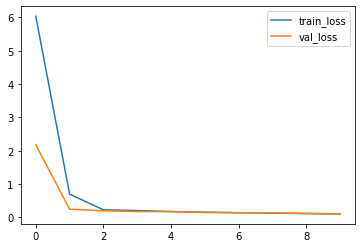

In [85]:
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

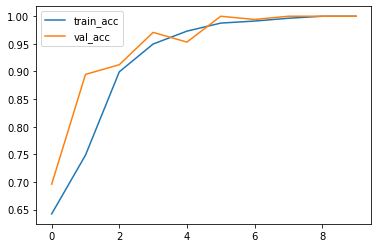

In [86]:
plt.plot(history.history['accuracy'],label='train_acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()

## Multilayer perceptron: tf.keras.layers.Dense. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer

In [87]:
from tensorflow.keras.layers import Dense
layer1 = Dense(2, activation="relu", name="layer1")
layer2 = Dense(3, activation="sigmoid", name="layer2")
layer3 = Dense(4, name="layer3")

# Call layers on a test input
x = tf.ones((3, 3))
y = layer3(layer2(layer1(x)))
y

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-0.04710329,  0.696536  , -0.23101139,  0.56739706],
       [-0.04710329,  0.696536  , -0.23101139,  0.56739706],
       [-0.04710329,  0.696536  , -0.23101139,  0.56739706]],
      dtype=float32)>

In [88]:
# DEFINICION
# tf.keras.layers.Dense(
#     units, activation=None, use_bias=True,
#     kernel_initializer='glorot_uniform',
#     bias_initializer='zeros', kernel_regularizer=None,
#     bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,name='')
# 
model = Sequential(
    [
        Dense(2, activation="relu", name="layer1"),
        Dense(3, activation="sigmoid", name="layer2"),
        Dense(4, name="layer3"),
    ],name='my_first_model'
)

x = tf.ones((3, 3))
y = model(x)
y

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-0.04899861,  0.1343101 , -0.09260553, -0.23593861],
       [-0.04899861,  0.1343101 , -0.09260553, -0.23593861],
       [-0.04899861,  0.1343101 , -0.09260553, -0.23593861]],
      dtype=float32)>

In [89]:
model.layers

In [90]:
model.layers[2].weights

[<tf.Variable 'layer3/kernel:0' shape=(3, 4) dtype=float32, numpy=
 array([[-0.14695722,  0.77367234, -0.13666755, -0.29182518],
        [-0.6078937 ,  0.40985405, -0.47859797,  0.07799816],
        [ 0.5565276 , -0.85858274,  0.35722172, -0.21765924]],
       dtype=float32)>,
 <tf.Variable 'layer3/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

In [91]:
model.summary()

Model: "my_first_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (3, 2)                    8         
                                                                 
 layer2 (Dense)              (3, 3)                    9         
                                                                 
 layer3 (Dense)              (3, 4)                    16        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [92]:
## Input layer
initial_model = Sequential(
    [
        #tf.keras.Input(shape=(3, 3)), ##1
        #tf.keras.layers.InputLayer(input_shape=(3,3)), ##2
        Dense(2, activation="relu", input_shape=(3,3), name="layer1"), ##3
        #Dense(2, activation="relu", name="layer1"),
        Dense(3, activation="sigmoid", name="layer2"),
        Dense(4, name="layer3")
    ]
)
initial_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3, 2)              8         
                                                                 
 layer2 (Dense)              (None, 3, 3)              9         
                                                                 
 layer3 (Dense)              (None, 3, 4)              16        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [93]:
initial_model.input

<KerasTensor: shape=(None, 3, 3) dtype=float32 (created by layer 'layer1_input')>

In [94]:
initial_model.output

<KerasTensor: shape=(None, 3, 4) dtype=float32 (created by layer 'layer3')>

In [95]:
model = Sequential()
model.add(tf.keras.Input(shape=(3,3)))
model.add(Dense(2, activation="relu"))
model.add(Dense(3, activation="sigmoid"))
model.add(Dense(4, activation="relu"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3, 2)              8         
                                                                 
 dense_5 (Dense)             (None, 3, 3)              9         
                                                                 
 dense_6 (Dense)             (None, 3, 4)              16        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.trainable_variables

[<tf.Variable 'dense_4/kernel:0' shape=(3, 2) dtype=float32, numpy=
 array([[-0.5297162 , -0.84853625],
        [ 0.960196  , -0.79634607],
        [-0.2190938 ,  0.6095326 ]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'dense_5/kernel:0' shape=(2, 3) dtype=float32, numpy=
 array([[-0.3480215 ,  1.0749462 , -1.0082487 ],
        [ 0.30233037,  0.6011573 ,  0.09464991]], dtype=float32)>,
 <tf.Variable 'dense_5/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_6/kernel:0' shape=(3, 4) dtype=float32, numpy=
 array([[-0.53219604,  0.6827649 ,  0.15026557, -0.33019298],
        [-0.8634386 ,  0.09728658,  0.4566108 ,  0.48124123],
        [ 0.3750322 ,  0.39248395,  0.38431883, -0.11727661]],
       dtype=float32)>,
 <tf.Variable 'dense_6/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

In [97]:
for layer in model.layers:
  print(layer.trainable)

True
True
True


In [98]:
model.trainable = False

model.trainable_variables

[]

In [99]:
for layer in model.layers:
  print(layer.trainable)

False
False
False


In [100]:
model = Sequential()
model.add(tf.keras.Input(shape=(3,3)))
model.add(Dense(2, activation="relu", name="layer1"))
model.add(Dense(3, activation="sigmoid", name="layer2"))
model.add(Dense(4, activation="relu", name="layer3"))
model.add(Dense(5, activation="relu", name="layer4"))
model.add(Dense(6, activation="sigmoid", name="layer5"))
model.add(Dense(7, activation="relu", name="layer6"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3, 2)              8         
                                                                 
 layer2 (Dense)              (None, 3, 3)              9         
                                                                 
 layer3 (Dense)              (None, 3, 4)              16        
                                                                 
 layer4 (Dense)              (None, 3, 5)              25        
                                                                 
 layer5 (Dense)              (None, 3, 6)              36        
                                                                 
 layer6 (Dense)              (None, 3, 7)              49        
                                                                 
Total params: 143
Trainable params: 143
Non-trainable 

In [101]:
#"Functional API"
feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="layer4").output,name='model_intermediate'
)
feature_extractor

In [102]:
feature_extractor.summary()

Model: "model_intermediate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 3)]            0         
                                                                 
 layer1 (Dense)              (None, 3, 2)              8         
                                                                 
 layer2 (Dense)              (None, 3, 3)              9         
                                                                 
 layer3 (Dense)              (None, 3, 4)              16        
                                                                 
 layer4 (Dense)              (None, 3, 5)              25        
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


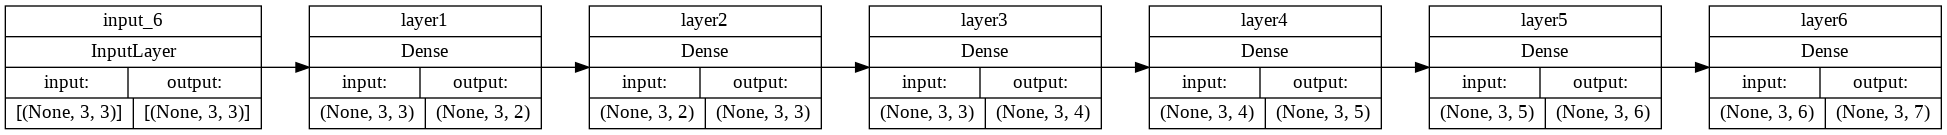

In [108]:
tf.keras.utils.plot_model(
    model,
    rankdir= 'LR',#"TB",
    to_file="model.png",
    show_shapes=True,
    show_layer_activations=False)


In [120]:
#"Functional API"
inputs = tf.keras.Input(shape=(784,), name='datos')
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='model')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 datos (InputLayer)          [(None, 784)]             0         
                                                                 
 dense_19 (Dense)            (None, 64)                50240     
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [125]:
inputs = tf.keras.Input(shape=(32, 32, 3), name='img')
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
block_1_output = layers.Dense(64, activation='relu')(x)

x = layers.Dense(32, activation='relu')(block_1_output)
x =  layers.Dense(64, activation='relu')(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Dense(32, activation='relu')(block_2_output)
x = layers.Dense(64, activation='relu')(x)
block_3_output = layers.add([x, block_2_output])

x =  layers.Dense(16, activation='relu')(block_3_output)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs, name='very_densee')
model.summary()


Model: "very_densee"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 dense_36 (Dense)               (None, 32, 32, 64)   256         ['img[0][0]']                    
                                                                                                  
 conv2d_2 (Conv2D)              (None, 30, 30, 64)   36928       ['dense_36[0][0]']               
                                                                                                  
 dense_37 (Dense)               (None, 30, 30, 64)   4160        ['conv2d_2[0][0]']               
                                                                                        

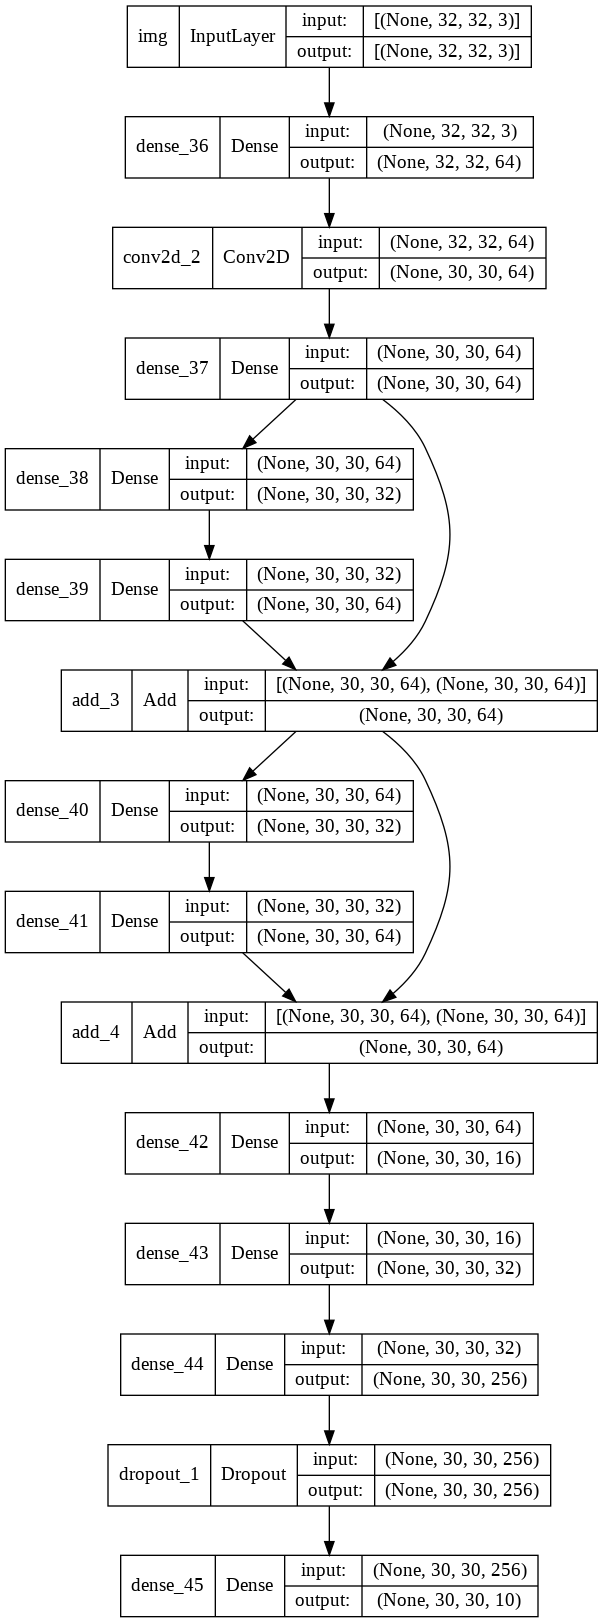

In [127]:
tf.keras.utils.plot_model(model, show_shapes=True)


### Personalizar Layers y Models

In [164]:
###Clase Layer
class Mylayer(tf.keras.layers.Layer):

  def __init__(self, units=1):
      super(Mylayer, self).__init__()
      self.units = units

  def build(self, input_shape):  
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(
        initial_value=w_init(shape=(input_shape[-1], self.units),
                             dtype='float32'),
        trainable=True)
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(
        initial_value=b_init(shape=(self.units,), dtype='float32'),
        trainable=True)

  def call(self, inputs):  
      return tf.matmul(inputs, self.w) + self.b


linear_layer = Mylayer(8)


y = linear_layer(tf.ones((1, 2)))
y

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[-0.05260085, -0.03998625, -0.00377731, -0.06373285, -0.03482005,
        -0.02006784,  0.0434394 ,  0.08782867]], dtype=float32)>

In [165]:
###Clase MODEL
class MyModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.dense1 = layers.Dense(2, 'relu')
    self.dense2 = layers.Dense(4, 'relu')
    self.dense3 = layers.Dense(8, 'elu')

  def call(self, inputs, training=False):
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.dense3(x)
    if not training:
      self.dense3.trainable = False 
    return x

model = MyModel()

y = model(tf.ones((1, 2))*2,training=False)
print('resultado:',y)
model.summary()

resultado: tf.Tensor(
[[ 0.801561   -0.9615831  -0.9084618   1.6300173  -0.07950217 -0.5428909
  -0.9508414  -0.9470691 ]], shape=(1, 8), dtype=float32)
Model: "my_model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           multiple                  6         
                                                                 
 dense_151 (Dense)           multiple                  12        
                                                                 
 dense_152 (Dense)           multiple                  40        
                                                                 
Total params: 58
Trainable params: 18
Non-trainable params: 40
_________________________________________________________________
